### <center>Numpy Choice Algorithm</center> ###



Numpy's choice algorithm is defined in the source file "_generator.pyx", and is an element of the Generator class returned when calling default_rng(). Note that generator can be instantiated manually, and wraps a numpy bit_generator, which is a prng, i.e. PCG64, mt19337, etc. 

The default prng is PCG64, which is significantly faster than mt19337 and passes more statistical tests, so there is no reason to deviate in our use case. 

$ CDF = \begin{bmatrix}
           w_{0} \\
           w_{0}+w{1} \\
           \vdots \\
           w_{0}+...+w_{n-1}
         \end{bmatrix} $


where $\sum_{i=0}^{n-1}w_{i} = 1 $

and the final element of the CDF is 1.

The algorithm that numpy uses is referred to in the literature as multinomial resampling, where samples are drawn independently on the interval
$ u_i = [0,1) $ and $i$ between $0$ and $n-1$.

so $ U =  \begin{bmatrix}
           u_{0} \\
           u_1 \\
           \vdots \\
           u_{i}
         \end{bmatrix} $

We then take all the samples and evaluate at which index in $CDF$ they could be inserted while maintaining order, 
this is the function cdf.searchsorted(uniform_samples) which is a binary search implementation which returns a vector of 
indices. This resampling algorithm will have a time complexity of $O(nlogn)$ as the $logn$ binary search must be run over every sample.

![Alt text](image.png)



In [33]:
import numpy as np

gen = np.random.default_rng()
orig_weights = np.array([gen.random() for _ in range(10)])
orig_weights /= np.sum(orig_weights)

numpy_weights = np.copy(orig_weights)
numpy_weights /= np.sum(numpy_weights)

'''The numpy resampling algorithm as defined in numpy.random.Generator.choice, generates N random samples from a uniform distribution (0,1)
and performs a binary search to obtain the index in the sorted CDF where the samples would be inserted to maintain order

Time complexity O(nlogn) where n is the number of samples, in our case n = len(weights)

https://github.com/numpy/numpy/blob/64fc516a0fce06169a1e0fea55c7cd2dc57cd296/numpy/random/_generator.pyx#L3084
'''
def numpy_choice(weights): 
    cdf = weights.cumsum() #cumulative sum stored in np.array
    cdf /= cdf[-1] #normalization done in function
    uniform_samples = gen.random(weights.shape)
    idx = cdf.searchsorted(uniform_samples, side='right') #a binary search over the array
    return idx
idx=numpy_choice(numpy_weights)
print(f"indices drawn from numpy choice: {idx}")

indices drawn from numpy choice: [3 7 2 1 2 8 3 2 2 2]


### <center> The Systematic Resampling Algorithm  ###

Another approach to resampling is the systematic resampling algorithm, this algorithm is faster than the multinomial algorithm and it can be shown that it preserves a greater number of samples from 
the original weight distribution.

We first construct the cdf in the same manner as above. 

$ CDF = \begin{bmatrix}
           w_{0} \\
           w_{0}+w{1} \\
           \vdots \\
           w_{0}+...+w_{n-1}
         \end{bmatrix} $


where $\sum_{i=0}^{n-1}w_{i} = 1 $

and the final element of the CDF is 1.

We then draw a random number $ u = [0,\frac{1}{len(weights)})$. 

Now we can iterate over the $CDF$ and compare the value of $r$ to $CDF[i]$ where $r = (u + 1/len(weights)*j) $

and $i,j$ are iterators. If the while loop passes r then we stop incrementation of $i$ and record the index at which i landed.

This algorithm has a time complexity of $O(n)$ as we only iterate over the $CDF$ once


A slightly different but functionally equivalent formulation:

![Alt text](image-2.png)


![Alt text](image-1.png)



In [34]:
'''The systematic resampling algorithm uses a slightly different approach, assuming that we are drawing n samples where n=len(weights),
numpy cannot assume this as it supports drawing fewer samples than len(weights). 

We draw only 1 random sample u=U(1/n) as offset the subsequent n-1 indices by u +(1/n)*j, this has multiple advantages, firstly, if the weights are
uniform the indices will not change, secondly, the time complexity is only O(n) as no search step is required

Note also that the indices and resampled in sorted order, although for our case this doesn't matter, it's worth noting 
'''
systematic_weights = np.copy(orig_weights)
systematic_weights /= np.sum(systematic_weights)

def systematic_choice(weights): 
    indices = np.zeros(len(weights)) #initialize array to hold the indices
    cdf = np.cumsum(weights) #create cdf
    u = gen.uniform(0,1/len(weights)) #random number between 1 and 1/n, only drawn once vs the n 
    i=0
    for j in range(0,len(weights)): 
        r = (u + 1/len(weights) * j)
        while r > cdf[i]: 
            i += 1
        indices[j] = i
    return indices
indices = systematic_choice(systematic_weights)
print(f"indices drawn from systematic resampling: {indices}")



indices drawn from systematic resampling: [0. 1. 2. 2. 2. 3. 3. 5. 8. 9.]


### <center> Resampling in the Log-Domain ###

While systematic resampling can be easily performed in the log domain, we require a special function to normalize the weights and compute the log-CDF, the Jacobian Logarithm as defined below.

![Alt text](image-3.png)

We can calculate the Jacobian Logarithm iteratively using: 

![Alt text](image-4.png)

This will allow us to normalize our weights and compute the $CDF$ in the log domain.

![Alt text](image-5.png)

Now we can calculate the log-CDF and perform systematic resampling in the log domain: 

![Alt text](image-6.png)

However in python we must index from $0$ to $n-1$ as opposed to $1$ to $n$.
Also note that if j = 1, then is assigned $[u]_1 = ln([u]_1) $

I believe this is a notational error as we don't want $[u]_1$ to be on the log scale or a negative number. Then on subsequent passes of $j$ the indices are 
returned as $NaN$ and only index $0$ is sampled. 

I have fixed this error in the code below, I don't hold the vector of $[u]$ and just hold the current value, as the whole vector is never called back on or queried. 


In [35]:

import numpy as np
'''The jacobian logarithm, used in log likelihood normalization and resampling processes
δ will be an array of log-probabilities '''
def jacob(δ):
    n = len(δ)
    Δ = np.zeros(n)
    Δ[0] = δ[0]
    for i in range(1,n):
        Δ[i] = max(δ[i],Δ[i-1]) + np.log(1 + np.exp(-1*np.abs(δ[i] - Δ[i-1])))
    return(Δ)

'''normalizes the probability space using the jacobian logarithm as defined in jacob() '''
def log_norm(log_weights): 
    norm = (jacob(log_weights)[-1])
    log_weights -= norm
    return log_weights


'''The systematic resampling in log domain is functionally equivalent to doing so in the lin-domain, but requires a special helper function, 
the jacobian logarithm, i.e. log(sum(exp(x1)+exp(x2) + ... + exp(xn)))'''


def log_systematic(weights): 
    log_weights = np.copy(weights)
    log_weights = np.log(log_weights)
    log_weights = log_norm(log_weights) 

    log_cdf = jacob(log_weights) #construct log_cdf using the jacobian log
            
    i = 0
    indices = np.zeros(len(log_weights))
    u = gen.uniform(0,1/len(log_weights))
    for j in range(0,len(log_weights)): 
        r = np.log(u + 1/len(log_weights) * j)
        while r > log_cdf[i]: 
            i += 1
        indices[j] = i

    return indices

indices = log_systematic(orig_weights)

print(f"indices drawn from log systematic resampling: {indices}")


indices drawn from log systematic resampling: [0. 0. 1. 2. 2. 2. 3. 3. 6. 8.]


### <center> Benchmarking and Numerical Tests ###

test weights: [0.16762097 0.03641398 0.14525574 0.02617444 0.08991282 0.02383152
 0.12081251 0.1475882  0.0746068  0.16778303]

test weights sum: 0.9999999999999998
numpy run time for 1000 samples: 0.005285500083118677
differences: [0.00172097 0.00031398 0.00054426 0.00107444 0.00208718 0.00156848
 0.00208749 0.0032882  0.0004932  0.00038303]





systematic resampling run time for 1000 samples: 0.009735900210216641
differences: [2.09678424e-05 1.48602118e-03 2.25573759e-03 2.55552260e-05
 4.87183678e-04 5.68478210e-04 1.58749469e-03 1.98819656e-03
 8.93198305e-04 7.83029295e-04]





systematic log resampling run time for 1000 samples: 0.08749589999206364
differences: [0.00172097 0.00031398 0.00054426 0.00107444 0.00208718 0.00156848
 0.00208749 0.0032882  0.0004932  0.00038303]


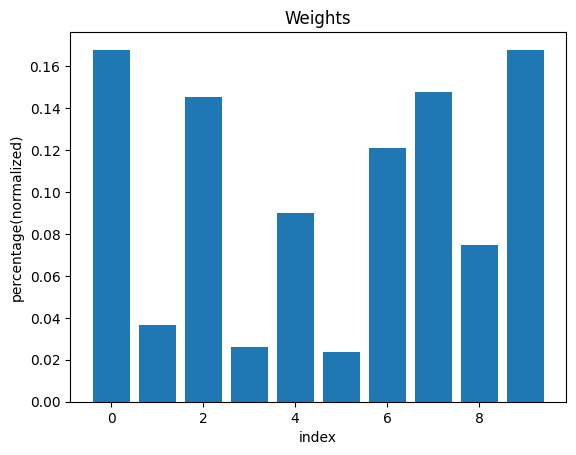

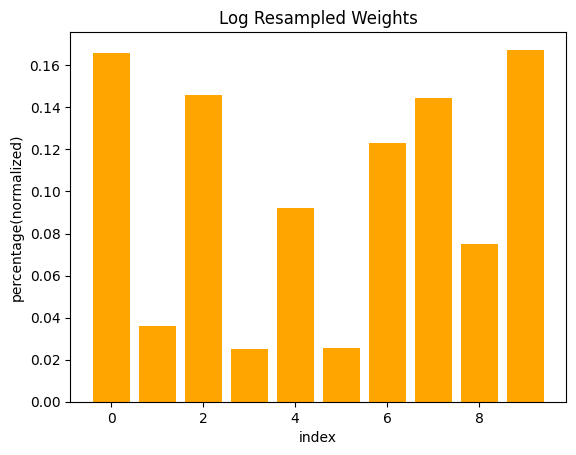

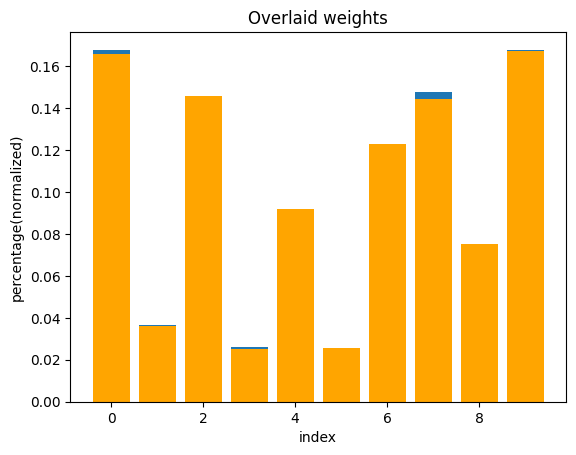

In [37]:
from time import perf_counter
import matplotlib.pyplot as plt

test_gen = np.random.default_rng(10)
test_weights = np.array([test_gen.random() for _ in range(10)])
test_weights /= np.sum(test_weights)

print(f"test weights: {test_weights}\n")
print(f"test weights sum: {np.sum(test_weights)}")

t1 = perf_counter()
all_samples_numpy = np.array([numpy_choice(test_weights) for _ in range(1000)])
t2 = perf_counter()

print(f"numpy run time for 1000 samples: {t2-t1}")

all_samples_numpy = all_samples_numpy.flatten()
all_samples_numpy= np.sort(all_samples_numpy)

sample_count_numpy = []
for i in range(0,10): 
    sample_count_numpy.append(np.count_nonzero(all_samples_numpy == i)/len(all_samples_numpy))
    #print(f"percentage of elements equal to {i} is {sample_count_numpy[-1]}, orignal weight:{orig_weights[i]}")
print(f"differences: {np.abs(test_weights-sample_count_numpy)}")

print("\n\n\n\n")


t3 = perf_counter()
all_samples_systematic= np.array([systematic_choice(test_weights) for _ in range(1000)])
t4 = perf_counter()

print(f"systematic resampling run time for 1000 samples: {t4-t3}")

all_samples_systematic = all_samples_systematic.flatten()
all_samples_systematic= np.sort(all_samples_systematic)

sample_count_systematic = []
for i in range(0,10): 
    sample_count_systematic.append(np.count_nonzero(all_samples_systematic == i)/len(all_samples_systematic))
    #print(f"percentage of elements equal to {i} is {sample_count_systematic[-1]}, original weight:{test_weights[i]}")
print(f"differences: {np.abs(test_weights-sample_count_systematic)}")


print("\n\n\n\n")


t5 = perf_counter()
all_samples_log = np.array([log_systematic(test_weights) for _ in range(1000)])
t6 = perf_counter()

print(f"systematic log resampling run time for 1000 samples: {t6-t5}")

all_samples_log = all_samples_log.flatten()
all_samples_log= np.sort(all_samples_numpy)

sample_count_log = []
for i in range(0,10): 
    sample_count_log.append(np.count_nonzero(all_samples_log == i)/len(all_samples_log))
    #print(f"percentage of elements equal to {i} is {sample_count_log[-1]}, original weight:{test_weights[i]}")
print(f"differences: {np.abs(test_weights-np.array(sample_count_log))}")


'''test weights'''
t = np.arange(0,10)
plt.title("Weights")
plt.bar(t,test_weights)
plt.xlabel("index")
plt.ylabel("percentage(normalized)")
plt.show()

'''log weights'''
t = np.arange(0,10)
plt.title("Log Resampled Weights")
plt.bar(t,np.array(sample_count_log),color='orange')
plt.xlabel("index")
plt.ylabel("percentage(normalized)")
plt.show()

'''weights overlaid'''
t = np.arange(0,10)
plt.title("Overlaid weights")
plt.bar(t,test_weights)
plt.bar(t,np.array(sample_count_log),color='orange')
plt.xlabel("index")
plt.ylabel("percentage(normalized)")
plt.show()

